# computation of the line-of-sight velocity dispersion of a stellar system

This is a standard spherical Jeans analysis, that proceeds as follows :
* choose a 2D surface brightness profile $I(R)$ for the stellar system. This defines the 3D stellar density $\nu(r)$ as well.
* Choose a sDM density rho(r), which also yields its integral mass within radius $s$ $M(s)$
* Then apply the following two equations to obtain $\sigma^2_{los}$:
\begin{align}
\sigma^2_{los} &= \frac{2}{I(R)}\int_R^\infty \left(1-\beta\frac{R^2}{r^2}\right)\nu(r)\sigma^2(r)\frac{r{\rm d}r}{\sqrt{r^2-R^2}}\\
\nu(r)\sigma^2(r) &= \int_r^\infty \left(\frac{s}{r}\right)^{2\beta}\nu(s)\frac{GM(s)}{s^2}{\rm d}s
\end{align}


A common choice for the stellar density and surface brightness is the so-called Plummer profile :
\begin{align}
\nu(r) &= \frac{\rho_h}{\left(1+(\frac{r}{r_h})^2\right)^{5/2}} \\
I(R) &= \frac{4}{3}\frac{\rho_h r_h}{\left(1+(\frac{R}{r_h})^2\right)^2}
\end{align}

In [196]:
def nu(r,rh,rhoh):
    return rhoh * (1 + (r/rh)**2)**(-5./2.)
def I(R,rh,rhoh):
    return 4./3. * rh*rhoh/(1+(R/rh)**2)**2

For the spherical Dark Matter profile, we will use the generalized NFW profile :
\begin{equation}
\rho(r) = \frac{\rho_0}{\left(\frac{r}{r_0}\right)^a\left(1+(\frac{r}{r_0})^b\right)^\frac{c-a}{b}}
\end{equation}
with the standard NFW profile corresponding to $(a,b,c)=(1,1,3)$.
The enclosed mass can be analytically computed :
\begin{align}
M(s) &= \int_0^s 4\pi r^2 \rho(r){\rm d}r \\
     &= 4\pi\rho_0 r_0^3 \int_0^{s/r_0} \frac{x^{2-a}}{(1+x^b)^\frac{c-a}{b}} {\rm d}x \\
     &= \frac{4\pi\rho_0 r_0^3}{(3 - a)} x^{3 - a}{}_2F_1\left[\frac{3 - a}{b}, \frac{-a + c}{b}, \frac{3 - a + b}{b}, -x^b\right]\quad x=\frac{s}{r_0}\\
     &= \mu_0\;\mu(x)
\end{align}

In the strict NFW case, with $(a,b,c)=(1,1,3)$, the integral simplifies into $\mu(x)=\ln(1+x)-\frac{x}{1+x}$, and $\mu_0=4\pi\rho_0 r_0^3$

This results in :
\begin{align}
\nu(r)\sigma^2(r) &= G\mu_0\;r^{-2\beta}\;\int_r^\infty s^{2\beta}\nu(s)\frac{\mu(s/r_0)}{s^2}{\rm d}s\\
&= G\mu_0\rho_h\;r^{-2\beta}\;\int_r^\infty \frac{s^{2\beta}}{\left(1+(\frac{s}{r_h})^2\right)^{5/2}}\frac{\mu(s/r_0)}{s^2}{\rm d}s\\
&= G\mu_0\rho_hr_h^{-1}\;\left(\frac{r}{r_h}\right)^{-2\beta}\;\int_\frac{r}{r_h}^\infty \frac{y^{2\beta-2}}{\left(1+y^2\right)^{5/2}}\mu(y\,r_h/r_0){\rm d}y \quad\quad y=s/r_h\\
\sigma^2_{los}(R) &= \frac{2G\mu_0\rho_hr_h^{-1}}{I(R)}\int_R^\infty \left(1-\beta\frac{R^2}{r^2}\right)\frac{r{\rm d}r}{\sqrt{r^2-R^2}}\left(\frac{r}{r_h}\right)^{-2\beta}\;\int_\frac{r}{r_h}^\infty \frac{y^{2\beta-2}}{\left(1+y^2\right)^{5/2}}\mu(y\,r_h/r_0){\rm d}y\\
&= \frac{2G\mu_0\rho_h}{I(R)}\left(\frac{R}{r_h}\right)^{1-2\beta}\int_1^\infty \left(1-\frac{\beta}{z^2}\right)\frac{z^{1-2\beta}{\rm d}z}{\sqrt{z^2-1}}\;\int_\frac{zR}{r_h}^\infty \frac{y^{2\beta-2}}{\left(1+y^2\right)^{5/2}}\mu(y\,r_h/r_0){\rm d}y
\end{align}

We can note the following :
* $\rho_h/I(R)$ is independent of $\rho_h$, which thus can be set arbitrarily to 1;
* if we neglect the dependency on $r_0$ of the double integral for a moment, we can immediately see that $\rho_0$ and $r_0$ are quite degenerate, as they appear in $\sigma_{los}$ as a product $\rho_0r_0^3$. This fact also justifies that one may be better off using the parameter $M_0=\rho_0r_0^3$ instead of $\rho_0$;
* a minimization procedure will be penalized if it requires recomputation of the double integral each time it changes $\rho_0$ only. The easiest way out in case of a Likelihood formulation is to use a profiled likelihood method, where $\rho_0$ is fitted (fast evaluations) while $r_s$ is scanned over (slow double integrand computation, but performed only once per $r_s$ value);
* units are carried over to $\sigma^2_{los}$ by the product $GM_0/r_h$, which usually is to be defined in km$^2$s$^{-2}$, while $r_h$ (together with $r_0$ and $R$) is given in kpc. Donc :
\begin{equation}
\frac{GM_0[\rm kg]}{r_h[\rm m]}\; {\rm m^2}{\rm s}^{-2} = 4.3\,10^{-6} \frac{M[M_\odot]}{r_h[\rm kpc]} \; {\rm km^2}{\rm s}^{-2} 
\end{equation}

which means that a galaxy with mass $10^6-10^8$ solar masses will result in a line-of-sight squared velocity dispersion of order $1-10^2 \;{\rm km}^2{\rm s}^{-2} $


In [197]:
from scipy import special
import numpy as np
from matplotlib import pylab as plt
from scipy.integrate import quad,quadrature
%matplotlib inline

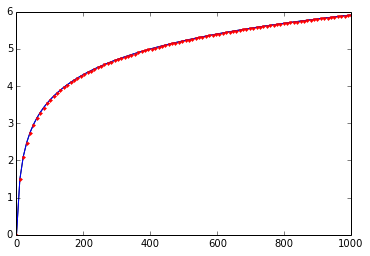

In [198]:
# Contained mass of the DM halo : generalized NFW
a=1.
b=1.
c=3.
def mu(x):
    return x**(3.-a)*special.hyp2f1((3.-a)/b, (c-a)/b, (-a+b+3.)/b,-x**b)

def dmass(u,a,b,c):
    #return pow( u, 2.-a)/pow(1. + pow(u,b), (c-a)/b )
    return u/(1. + u)**2

def get_M(x):
    return quad(dmass, 0., x, args=(a,b,c))[0]

def get_M_NFW(x):
    #this is the analytic formula
    #the constant is 4pi*rho0*rs^3
    return np.log(1.+x)-x/(1.+x)
    
    
x = np.linspace(0, 1000, 100)
yy = [get_M(xx) for xx in x]
plt.plot(x,mu(x)/(3.-a),'k')
plt.plot(x,yy, 'b')
plt.plot(x,get_M_NFW(x),'.r')
# The special function breaks out at 10^14, before the quad integration start showing issues

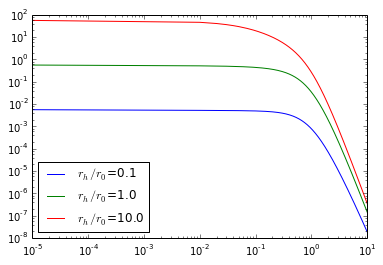

In [199]:
beta=-0.005
def integrand1(y,alpha,beta):
    result = nu(y, 1, 1)*get_M_NFW(y*alpha)/y**(2.-2.*beta)
    return result

#alpha=rh/r0
#start=zR/rh
alpha=1
start=1.e-5
for alpha in [0.1,1,10]:
    int1_y=np.linspace(1.e-5, 10, 1000)
    plt.loglog(int1_y,integrand1(int1_y,alpha,beta),label=r"$r_h/r_0$=%.1f"%alpha)
plt.legend(loc=3)

One can see in the plot above that the first integrand scales at $\alpha^2$ with $\alpha=r_h/r_0$. This is due to the fact that $M(s)$ goes like $s^2$ at small $s$ for an NFW profile. 
Then the first integrand cuts off at large $y$ with a weak dependency on $\alpha$ :  at large $y$, the integrand goes like $y^{-5}y^{2\beta-2}\log(\alpha x)$ so the numerical integration to infinity should really be well-behaved.

In [200]:
def integral1(ymin,alpha,beta):
    res,err = quad(integrand1,ymin,+np.inf,args=(alpha,beta),
                   epsabs=1.e-10,epsrel=1.e-10,limit=1000)
    return res, err

ymin_array=np.logspace(-4,6,100)
alpha_array=np.logspace(-4,4,100)
res_array=np.zeros((100,100))
err_array=np.zeros((100,100))
for i,ymin in enumerate(ymin_array):
    for j,alpha in enumerate(alpha_array):
        res_array[i,j], err_array[i,j]=integral1(ymin,alpha,beta)

3.37266536124e-09


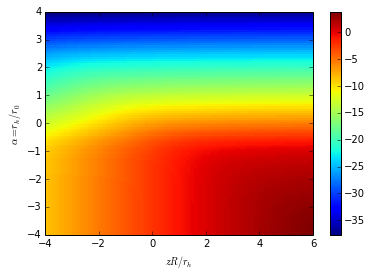

In [201]:
plt.pcolor(np.log10(ymin_array), np.log10(alpha_array),np.log10(res_array))
plt.colorbar()
plt.ylabel(r"$\alpha=r_h/r_0$")
plt.xlabel(r"$zR/r_h$")
print res_array[0,0]

<matplotlib.colorbar.Colorbar instance at 0x7f32c4df2680>

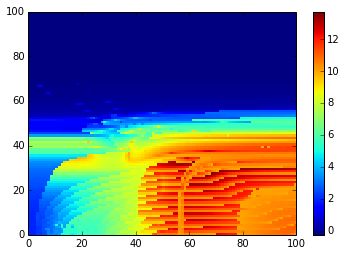

In [202]:
plt.pcolor(np.log10(res_array/err_array))
plt.colorbar()

In [203]:
def integrand2(z,alpha,beta,gamma):
    #gamma=R/rh
    result = (1.-beta/z**2) * z**(1.-2.*beta)/np.sqrt(z*z-1.)
    res, err = integral1(gamma*z,alpha,beta)
    return result * res
    

In [204]:
def integral2(alpha,beta,gamma):
    res, err = quad(integrand2,1.,+np.inf,args=(alpha,beta,gamma),
                   epsabs=1.e-10,epsrel=1.e-10,limit=1000)
    return res

print integral2(10, beta, 10)

3.69099920654e-07


#Likelihood formalism

\begin{align}
L &= \prod_{i=1}^N\frac{e^{-\frac{(v_i-u)^2}{2\sigma_i^2}}}{\sqrt{2\pi\sigma_i^2}} \quad{\rm with }\quad \sigma_i^2=\epsilon_i^2+\sigma_{los}^2(R_i,\rho_0, r_0) \\
{\cal L} = -\log L &= \frac{1}{2}\sum_{i=1}^N\left[\log(2\pi\sigma_i^2)+\frac{(v_i-u)^2}{\sigma_i^2}\right]
\end{align}

We can forget about the $2\pi$ in the minimization, but we can be clever about the way to proceed with minimizing ${\cal L}$, as mentioned above. First we need to look at typical data

In [1]:
from os import mkdir
from AT import get_data
dwarf = 'umaI'
#mkdir('/home/andrea/Desktop/work/DWARF/Jvalue/output/%s'%dwarf)
data = get_data(dwarf)
R=data[0]
v=data[1]
dv=data[2]
rh=data[3]
D=data[-2]
Nstars = data[-3]
u=v.mean()
dv2 = (v-u)**2

In [206]:
names = {'dra':"Draco",'seg1':"Segue 1",'umaI':"Ursa Major 1",'booI':"Bootes 1",
         'wil1':"Willman 1",'scl':"Sculptor",'for':"Fornax",'sgr':"Sagittarius",
         'com':"Coma Berenices"}

-55.6982051282
5.14923076923 2.30111053693


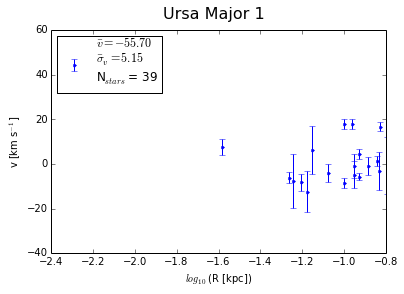

In [207]:
print v.mean() #this is u
print dv.mean(), (v.std()/dv.mean())**2
plt.errorbar(np.log10(R),v-v.mean(),dv,fmt='.',label=r'$\bar v = %.2f$'%v.mean()+'\n'+
             r'$\bar \sigma_v = %.2f$'%dv.mean()+'\n'+r'N$_{stars}$ = %i'%Nstars)
plt.ylim(-40,60)
plt.xlim(-2.4,-0.8)
plt.ylabel(r'v [km s$^{-1}$]')
plt.xlabel(r'$log_{10}$ (R [kpc])')
plt.legend(numpoints=1,loc='upper left',fontsize=12)
plt.suptitle('%s'%names[dwarf],fontsize=16)
plt.savefig('output/%s/vel_%s.png'%(dwarf,dwarf),dpi=300,format='png')

So the logical sequence would be :
* load data from param file. This gives $r_h$, the arrays $R$, $v$, $dv$, and $u$ is the average of $v$. Thus we can readily compute the array $\gamma$, with indice $i$, and then $A = \gamma^{1-2\beta}/I(R)$, where $\rho_h$ is set to 1 and $\gamma=R/r_h$. Remember that $r_h$ is provided in kpc, and there is another factor remaining : $8\pi GM_0$, that we deal with later ($8\pi G$ are kept in there to avoid numerical issues with small numbers, remember that in our units $G=4.3\times10^{-6}$);
* we define the array $r_0$ on which we are scanning ${\cal L}$, with indice $j$. This defines the array $\alpha=r_h/r_0$
* we compute the matrix $X_{i,j} = A_i I_{i,j}$ where $I_{i,j}$ is the integral value computed with $(\alpha_i,\gamma_j)$
* we compute ${\cal L}$ which now is an array in $j$; and a function of $\rho_0$, $M_0$, or $8\pi GM_0$, arbitrarily.

In [208]:
gamma_array = R/rh
A_array = gamma_array**(1.-2.*beta)/I(R,rh,1.)

r0_array = np.logspace(np.log10(0.1),np.log10(5.),50)
alpha_array = rh/r0_array
I_array=np.zeros(shape=(len(A_array),len(r0_array)))

#THIS IS THE PART THAT WILL TAKE MOST TIME
for i,gamma in enumerate(gamma_array):
    for j,alpha in enumerate(alpha_array):
        res = integral2(alpha,beta,gamma)
        I_array[i,j] = res *A_array[i]


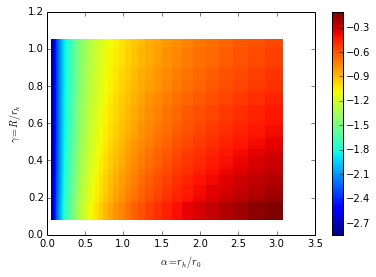

In [209]:
plt.pcolormesh(alpha_array, gamma_array,np.log10(I_array))
plt.colorbar()
plt.ylabel(r'$\gamma=R/r_h$')
plt.xlabel(r'$\alpha=r_h/r_0$')


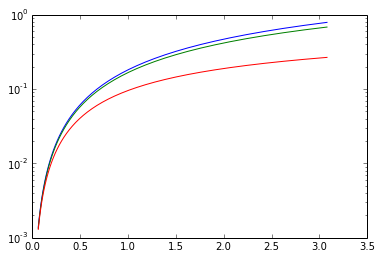

In [210]:
plt.semilogy(alpha_array, I_array[0,:])
plt.semilogy(alpha_array, I_array[2,:])
plt.semilogy(alpha_array, I_array[-1,:])


(2, 12)

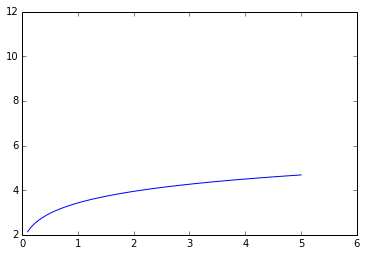

In [211]:
A=np.array([dv2/I_array[:,j] for j in range(len(r0_array))]).mean(axis=1)
plt.plot(r0_array,np.log10(A))
plt.ylim(2,12)

In [212]:
cst = 8.*np.pi*4.3e-6 #this is 1.08e-4, which means that the natural numerical unit for M0 is ~10^4 M_solar
#j is the r0 indice. In this way we vectorize computations as much as possible
def logLike(M0,j):
    I = cst*M0*I_array[:,j]
    S = dv**2+I
    res = (np.log(S) + (v-u)**2/S).sum()
    return res/2.


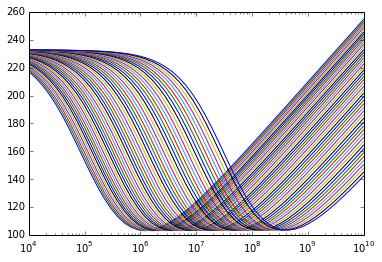

In [213]:
M0_array = np.logspace(4,10,50)
for j,r0 in enumerate(r0_array):
    LL_array = [logLike(M0,j) for M0 in M0_array]
    plt.semilogx(M0_array,LL_array,label=r"$r_0$=%.3f"%r0)
#plt.ylim(50,400)
#plt.xlim(10**4,10**15)
#plt.legend(loc=2,ncol=2)

In [214]:
from scipy import optimize as sciopt
def MinFunc(log10_M0,j):
    return logLike(10**log10_M0,j)
j=0
results = sciopt.minimize_scalar(MinFunc,args=(j,))
print results

  fun: 103.12290511514607
 nfev: 13
  nit: 12
    x: 6.0815179522291638


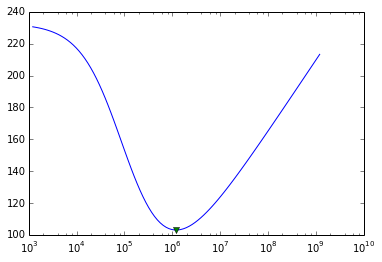

In [215]:
check_x=np.logspace(results['x']-3,results['x']+3,100)
check_y=[logLike(x,j) for x in check_x]
plt.semilogx(check_x,check_y)
plt.plot(10**results['x'],results['fun'],'v')

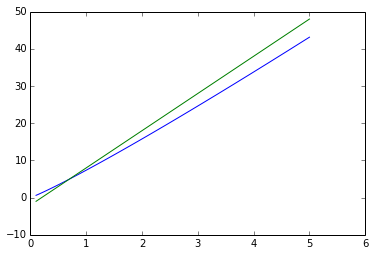

In [216]:
min_arrays = np.zeros_like(r0_array)
fmin_arrays = np.zeros_like(r0_array)
for j,r0 in enumerate(r0_array):
    results = sciopt.minimize_scalar(MinFunc,method='Bounded',bounds=(5,10),args=(j,))
    min_arrays[j]=results['x']
    fmin_arrays[j]=results['fun']
#plt.figure()
#plt.plot(r0_array,fmin_arrays,'.')
#plt.figure()
#plt.plot(min_arrays,fmin_arrays)
plt.figure()
plt.plot(r0_array,min_arrays*r0_array,'b')
plt.plot(r0_array,10*r0_array-2,'g')
#plt.ylim(0,10)

# Jfactor computation 

The Jfactor is the line-of-sight integral of the halo density, squared for annihilation but not for decay, further integrated in a small solid angle to take into account the limited angular resolution of gamma-ray telescopes.
The formula is :
  \begin{equation}
  \mathrm{J}(D,r_t,r_0,\rho_0,\theta_{\rm max}) = 2\pi\int\limits_0\limits^{\theta_{\rm max}}\sin\theta\;\mathrm{d}\theta\int\limits_{s_{\rm min}}\limits^{s_{\rm max}}\mathrm{d}s\;\rho^2(r(s))\quad \mathrm{GeV}^2\mathrm{cm}^{-5}\quad ,
  \end{equation}

where $r(s,\cos\theta)=\sqrt{s^2+D^2-2Ds\cos\theta}$ is the radius of an element of volume along the line of sight parameterized by the running variable $s$, bounded by $s_{\rm max/min} = D\cos\theta \pm \sqrt{r_t^2-D^2\sin^2\theta}$, with $r_t$ a cutoff radius of the halo, for instance the tidal radius, and $D$ the distance to the halo center.
Generically, the spherical profiles normally used to compute the J factor formally writes as $\rho(r)=\rho_0f(r/r_0)$ with $f$ some function defining the profile. Thus, it is convenient to make the change of variable $x=r/r_0$ and take the dimensional quantity out of the integrals :

\begin{equation}
  \mathrm{J}(D,rt,r_0,\rho_0,\theta_{max}) = 2\pi\rho_0^2r_0\int\limits_0\limits^{\theta_{\rm max}}\sin\theta\;\mathrm{d}\theta\int\limits_{x_{\rm min}}\limits^{x_{\rm max}}\mathrm{d}x\;f^2(r(x,\cos\theta))\quad \mathrm{GeV}^2\mathrm{cm}^{-5}\quad ,
  \end{equation}

with $r(x, \cos\theta)=\sqrt{x^2+(D/r_0)^2-2x(D/r_0)\cos\theta}$ and $x_{\rm max/min} = (D/r_0)\cos\theta \pm \sqrt{(r_t/r_0)^2-(D/r_0)^2\sin^2\theta}$. Simplifying the notation with $J'=J/(2\pi\rho_0^2r_0)$, $D'=D/r_0$ and $r'=r_t/r_0$, and performing the change of variable $y=\cos\theta$ in the outer integral, yields the nondimensional integral:

\begin{equation}
  \mathrm{J'}(D',rt',y_{\rm min}) = \int_{y_{\rm min}}^{1}\mathrm{d}y\int\limits_{x_{\rm min}}\limits^{x_{\rm max}}\mathrm{d}x\;f^2(r(x,y))\quad ,
  \end{equation}

with $r(x,y)=\sqrt{x^2+D'^2-2xD'y}$ and $x_{\rm max/min} = D'y \pm \sqrt{r'^2-D'^2(1-y^2)}$. $\theta_{max}$ is generally small positive, and thus $y_{\rm min}$ is smaller than and close to 1. Yet another change of variable, $z=x-D'y$, yields :

\begin{equation}
  \mathrm{J'}(D',r',y_{\rm min}) = \int_{y_{\rm min}}^{1}\mathrm{d}y\int\limits_{z_{\rm min}}\limits^{z_{\rm max}}\mathrm{d}z\;f^2(r(z,y))\quad ,
  \end{equation}

with $r(z,y)=\sqrt{z^2+D'^2(1-y^2)}$ and $z_{\rm max/min} = \pm \sqrt{r'^2-D'^2(1-y^2)}$. Now, $z$ appears as squared in the function $\rho$, so that the integrand is symmetric with respect to $z=0$. Given that the boundaries are equal and of opposite sign, the integral simplifies into :

\begin{equation}
  \mathrm{J'}(D',r',y_{\rm min}) = 2\int_{y_{\rm min}}^{1}\mathrm{d}y\int\limits_{0}\limits^{z_{\rm max}}\mathrm{d}z\;f^2(r(z,y))\quad .
  \end{equation}

To move ahead we now need to specialize to a profile. We consider the NFW profile $f(r)=r^{-1}(1+r)^{-2}$. The inner integral yields :

\begin{equation}
  \int\limits_{0}\limits^{z_{\rm max}}\mathrm{d}z\;f^2(r(z,y)) = \int\limits_{0}\limits^{z_{\rm max}}\mathrm{d}z\; \left(\sqrt{z^2+D'^2(1-y^2)}\right)^{-2}\left(1+\sqrt{z^2+D'^2(1-y^2)}\right)^{-4}\quad .
  \end{equation}

We note the divergence at $z\rightarrow0$ for $y\rightarrow1$. The last change of variable, $u=\sqrt{z^2+D'^2(1-y^2)}$ yields :
\begin{equation}
  \int\limits_{0}\limits^{z_{\rm max}}\mathrm{d}z\;f^2(r(z,y)) = \int\limits_{D'\sqrt{1-y^2}}\limits^{r'}\mathrm{d}u\; u^{-1}\left(u^2-D'^2(1-y^2)\right)^{-1/2}\left(1+u\right)^{-4}\quad ,
  \end{equation}

and so :

\begin{equation}
  \mathrm{J'}(D',r',y_{\rm min}) = 2\int_{y_{\rm min}}^{1}\mathrm{d}y\int\limits_{D'\sqrt{1-y^2}}\limits^{r'}\mathrm{d}u\; u^{-1}\left(u^2-D'^2(1-y^2)\right)^{-1/2}\left(1+u\right)^{-4}\quad .
  \end{equation}


In [217]:
import numpy as np
from math import sqrt,cos, log, pi
from scipy import integrate as sciint
rt=np.inf
ymin=cos(np.radians(0.5))

def func(u,y, D, rt):
    return (1.+u)**(-4)/u/sqrt(u*u-D**2*(1-y*y))

def lim_u(y, D, rt):
    return [D*sqrt(1-y*y), rt]

def lim_y(D, rt):
    return [ymin,1]

sciint.nquad(func, ranges=[lim_u, lim_y], args=(D,rt))

(3.140918142590151e-05, 7.043333596357115e-07)

In [218]:
d=np.logspace(1,3)
F=[sciint.nquad(func, ranges=[lim_u, lim_y], args=(Dist,rt))[0] for Dist in d]

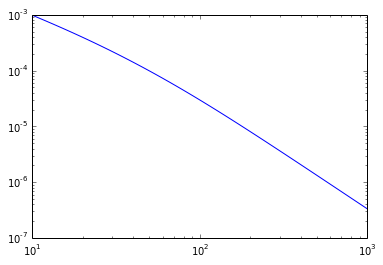

In [219]:
plt.loglog(d,F)

Finally, let's go back to dimensional quantities. We consider $\rho_0=M_\odot$ and $r_0=1\,\rm kpc$. $M_\odot=1.9891\,10^{30}\, \rm kg = 1.117471\,10^{57}\, \rm GeV$, and $1\, \rm kpc = 3.08567758\, 10^{21}\,\rm cm$. Thus :
$2\pi M_\odot^2\cdot \rm kpc = 2\pi(1.117471\,10^{57})^2/(3.08567758\, 10^{21})^5=2.8\,10^7\, \rm GeV^2\,\rm cm^{-5}$.
Thus a typical dwarf spheroidal with $\rho_0~10^8\,M_\odot$ and $r_0=0.1\,\rm kpc$ will have a natural scale of $\sim 2.8\,10^{22}\,\rm GeV^2\,\rm cm^{-5}$. The numerical integral above seems a factor 100 too low for a dwarf at $D=100 \rm kpc$ and a scale radius $r_0=0.1\,\rm kpc$, which give $D'=10^3$ and a non-dimensional integral close to $10^{-6}$

In [220]:
def Jfactor(D,rt,r0,rho0,tmax):
    """
    returns the Jfactor computed in the solid angle of
    semi apex angle tmax, in degree, for a NFW halo profile of 
    shape parameters (r0,rho0) at distance D. 
    rt is the maximal radius of integration 
    D, r0,  and rt are in kpc, and rho0 is in Msun.kpc^-3
    """
    ymin=cos(np.radians(tmax))
    Dprime=D/r0
    rtprime=rt/r0
    Msun2kpc5_GeVcm5 = 4463954.894661358
    cst = 4*pi*rho0**2*r0*Msun2kpc5_GeVcm5
    res = sciint.nquad(func, ranges=[lim_u, lim_y], args=(Dprime,rtprime),
                        opts=[{'epsabs':1.e-10,'epsrel':1.e-10,'limit':1000},
                              {'epsabs':1.e-10,'epsrel':1.e-10,'limit':1000}])
    #print res
    return cst*res[0]

J = Jfactor(D, np.inf, 0.141, 10**8.778, 0.5)
print J, np.log10(J)

2.00052934772e+18 18.3011449269


In [221]:
"""compare output of 2D integration with analytic expression"""
def f(u,D,y):
    Y = y*y-1.
    sqY = np.sqrt(Y)
    DYu = D**2.*Y+u**2.
    DY1 = D**2.*Y+1.
    sqDYu = np.sqrt(DYu)
    sqDY1 = np.sqrt(DY1)
    termA = D**4.*(6.*u**2+15.*u+11.)*Y**2.+D**2*(17.*u**2+45.*u+32.)*Y+26.*u**2.+60.*u+36.
    termB = 2.*D**6.*Y**3+7.*D**4.*Y**2.+8.*D**2.*Y+8.
    block1 = 2.*np.log(2.*D*(sqY*sqDYu+D*Y))/D/sqY
    block2 = sqDYu*termA*(u+1.)**-3.*DY1**-3./3.
    block3 = termB*np.log(-4.*DY1**3*(sqDY1*sqDYu+D**2.*Y-u))/DY1**3.5
    block4 = termB*np.log((u+1)*sqDY1*termB)/DY1**3.5
    block5 = 2.*np.log(D*u*sqY)/D/sqY
    return (-block1+block2+block3-block4+block5)/2.

def analyticF(D,rt,r0,rho0,tmax):
    ymin=cos(np.radians(tmax))
    Dprime=D/r0
    rtprime=rt/r0
    Msun2kpc5_GeVcm5 = 4463954.894661358
    cst = 4*pi*rho0**2*r0*Msun2kpc5_GeVcm5
    int_y = lambda y : f(rtprime,D,y)-f(Dprime*np.sqrt(1.-y*y),D,y)
    result = cst*sciint.quad(int_y,1.,ymin)[0]
    return result

# print analyticF(104,np.inf, 0.141, 10**8.778, 0.5)

Neglecting again the dependency on $r_0$ in the double integral in Eq. 19, we notice that even in $\mathrm{J}(D,r_t,r_0,\rho_0,\theta_{max})$ $\rho_0$ and $r_0$ are degenerate. However, accounting for this dependancy both in Eq. 14 and Eq. 19 and considering the different shapes of the degenerate product in each ($\rho_0 r_0^3$ in the former and $\rho_0^2 r_0$ in the latter) should result in two distinguishable behaviours of such functions over the parameter space.

In [222]:
rho0_array = np.logspace(6.,9.,50)
Jgrid = np.empty([len(rho0_array),len(r0_array)])
Lgrid = np.empty([len(rho0_array),len(r0_array)])
for i,rho0 in enumerate(rho0_array):
    for j,r0 in enumerate(r0_array):
        Jgrid[i,j] = Jfactor(D,np.inf,r0,rho0,0.5)
        Lgrid[i,j] = logLike(rho0*r0**3,j)
np.save('output/%s/Jgrid_%s'%(dwarf,dwarf),Jgrid)
np.save('output/%s/Lgrid_%s'%(dwarf,dwarf),Lgrid)

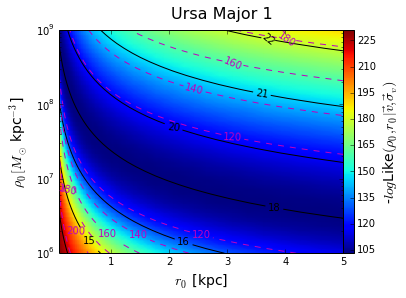

In [224]:
Jgrid = np.load('output/%s/Jgrid_%s.npy'%(dwarf,dwarf))
Lgrid = np.load('output/%s/Lgrid_%s.npy'%(dwarf,dwarf))
lplot = plt.pcolormesh(r0_array,rho0_array,Lgrid,shading='gouraud')
ctJ = plt.contour(r0_array,rho0_array,np.log10(Jgrid),colors='k')
ctL = plt.contour(r0_array,rho0_array,Lgrid,linestyles='dashed',colors='m')
plt.clabel(ctJ,inline=1,fmt='%1.0f',colors='k')
plt.clabel(ctL,inline=1,fmt='%1.0f',colors='m')
cx = plt.colorbar(lplot,pad=0)
cx.set_label(r'-$log$Like$(\rho_0,r_0|\vec v,\vec \sigma_v)$',fontsize=14)
plt.semilogy()
plt.ylabel(r'$\rho_0 [M_\odot$ kpc$^{-3}$]',fontsize=14)
plt.xlabel(r'$r_0$ [kpc]',fontsize=14)
plt.suptitle('%s'%names[dwarf],fontsize=16)
plt.savefig('output/%s/gridLJ_%s.png'%(dwarf,dwarf),dpi=300,format='png')

# Fitting scheme

Given the degeneracy of $\rho_0$ and $r_0$ in $\cal L$ and $J$ and their comparable shape, a standard fitting procedure would not lead to stable, thus reliable results. A way to circumvent this is to evaluate $\cal L$ of each $\textrm{J}$ value. This can be achieved in the following way:
* scan over a likely range of $\mathrm{J}$;
* for each $\mathrm{J}_i$, scan over one of the two variables. We have chosen $r_0$
* for each $r_{0j},$ find with a minimiser the $\rho_{0j}$ for which $\mathrm{J}_i - \mathrm{J}(D,r_t,r_{0j},\rho_{0j},\theta_{max}) \rightarrow 0$. Each examined $\mathrm{J}_i$ should thus lead to a set of coordinates $(r_{0j},\rho_{0j})$ from which the Likelihood can be mapped, giving $\cal L(\textrm{J}(r_{0j},\rho_{0j}))$
* interpolation gives $\cal L_{\textrm{J}_i}(r_0)$ and its minimum the highest likelihood value for $\textrm{J}_i$
* interpolating once again between the pairs $(\textrm{J}_i,\cal L_{\textrm{J}_i}(r_0))$ yields $\cal L(\textrm{J})$ and finding its minimum gives the maximum likelihood J for the given dwarf.

In [225]:
from scipy.interpolate import UnivariateSpline as spline
log10Jrho1 = np.log10([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])
def deltaJ(log10rho0,J,j):
    return abs(J-log10Jrho1[j]-2.*log10rho0)

The two following cells serve only to insert a marker in the previous plot to illustrate what the scheme should yield: a unique maximum likelihood point along each J isocurves

In [227]:
rho0star = np.empty([4])
r0star = np.empty([4])
for i,J in enumerate((16.,18.,20.,21.)):    # examine the 4 J isocurves most visible
    min_rho0J = sciopt.minimize_scalar(deltaJ,args=(J,29+i*2),tol=1.e-10)
    rho0star[i] = min_rho0J.x
    r0star[i] = r0_array[29+i*2] # for each J, evaluate rho0 at a different r0 close to 1kpc

#rho0star[0] += 0.26
#rho0star[2] -= 0.24

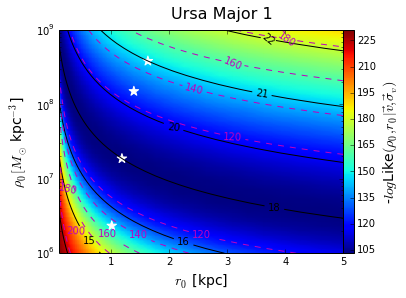

In [228]:
Jgrid = np.load('output/%s/Jgrid_%s.npy'%(dwarf,dwarf))
Lgrid = np.load('output/%s/Lgrid_%s.npy'%(dwarf,dwarf))
lplot = plt.pcolormesh(r0_array,rho0_array,Lgrid,shading='gouraud')
plt.scatter(r0star,np.power(10.,rho0star),marker='*',c='w',s=100,edgecolor='w')
ctJ = plt.contour(r0_array,rho0_array,np.log10(Jgrid),colors='k')
ctL = plt.contour(r0_array,rho0_array,Lgrid,linestyles='dashed',colors='m')
plt.clabel(ctJ,inline=1,fmt='%1.0f',colors='k')
plt.clabel(ctL,inline=1,fmt='%1.0f',colors='m')
cx = plt.colorbar(lplot,pad=0)
cx.set_label(r'-$log$Like$(\rho_0,r_0|\vec v,\vec \sigma_v)$',fontsize=14)
plt.semilogy()
plt.xlim(.1,5)
plt.ylim(1e6,1e9)
plt.ylabel(r'$\rho_0 [M_\odot$ kpc$^{-3}$]',fontsize=14)
plt.xlabel(r'$r_0$ [kpc]',fontsize=14)
plt.suptitle('%s'%names[dwarf],fontsize=16)
plt.savefig('output/%s/gridLJ_%s.png'%(dwarf,dwarf),dpi=300,format='png')

For some reason, two points do not lie on the corresponding J isocurve, while the other two appear to fall percetly on it

Given the similarity of the solid and dashed contours in the previous plot, we better examine the value of the $\cal L$ along a $\mathrm{J}$ isocurve

In [229]:
Jtest=18.
rho0j = np.zeros_like(r0_array)
LikeJj = np.zeros_like(r0_array)
for j,r0 in enumerate(r0_array):
    min_deltaJj = sciopt.minimize_scalar(deltaJ,args=(Jtest,j),tol=1.e-10)
    rho0j[j] = min_deltaJj.x
    LikeJj[j] = logLike(10.**min_deltaJj.x*r0**3.,j)

In [230]:
spline_LikeJ_r0 = spline(r0_array,LikeJj,s=0)
min_LikeJ_r0 = sciopt.minimize_scalar(spline_LikeJ_r0,tol=1.e-10)
print min_LikeJ_r0.x,spline_LikeJ_r0(min_LikeJ_r0.x)

0.349231839224 103.185840533


as a function of $r_0$

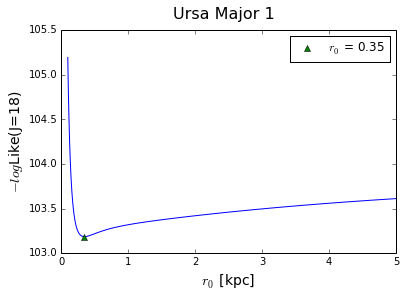

In [231]:
plt.plot(r0_array,LikeJj)
plt.plot(min_LikeJ_r0.x,spline_LikeJ_r0(min_LikeJ_r0.x),'^',
         label=r'$r_0$ = %.2f'%min_LikeJ_r0.x)
plt.xlim(0,5)
plt.xlabel(r'$r_0$ [kpc]',fontsize=14)
plt.ylabel(r'$-log$Like(J=%i)'%Jtest,fontsize=14)
plt.legend(numpoints=1,loc='upper right',fontsize=12)
plt.suptitle('%s'%names[dwarf],fontsize=16)
plt.savefig('output/%s/LikeJ%i_%s.png'%(dwarf,Jtest,dwarf),dpi=300,format='png')

and as a function of the corresponding $\rho_0$

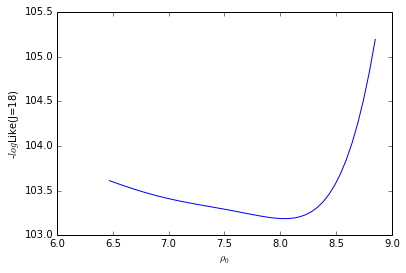

In [232]:
plt.plot(rho0j,LikeJj)
plt.xlabel(r'$\rho_0$')
plt.ylabel(r'-$log$Like(J=%i)'%Jtest)

We examine now the behaviour for neighbouring $\mathrm{J}$ values

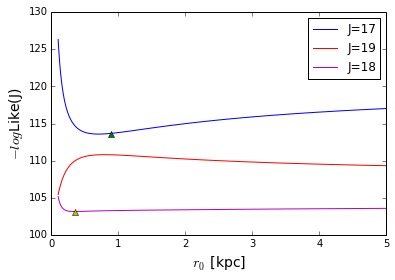

In [233]:
tmax=0.5
rt=np.inf
for J in (17,19):
    LikeJ_values = np.zeros_like(r0_array)
    for j,r0 in enumerate(r0_array):
        log10rho0j = sciopt.minimize_scalar(deltaJ,args=(J,j),tol=1e-10)
        LikeJ_values[j] = logLike(10.**log10rho0j.x*r0**3.,j)
    spline_LikeJ = spline(r0_array,LikeJ_values)
    min_LikeJ = sciopt.minimize_scalar(spline_LikeJ,bracket=(.01,2.),tol=1e-10)
    plt.plot(r0_array,LikeJ_values,label='J=%i'%J)
    plt.plot(min_LikeJ.x,spline_LikeJ(min_LikeJ.x),'^')
plt.plot(r0_array,LikeJj,label='J=%i'%Jtest)
plt.plot(min_LikeJ_r0.x,spline_LikeJ_r0(min_LikeJ_r0.x),'^')
plt.xlim(0,5)
plt.legend(numpoints=1,loc='upper right')
plt.xlabel(r'$r_0$ [kpc]',fontsize=14)
plt.ylabel(r'$-log$Like(J)',fontsize=14)
plt.savefig('output/%s/LikeJmulti_%s.png'%(dwarf,dwarf),dpi=300,format='png')

This indicates that there is a specific value of $\textrm{J}$ at which there is a turn-around in the shape of $\cal L$ as a function of $r_0$. This behaviour is consistent with contours shown in the colour map; compare $\cal L$ = 120 and $\textrm{J}$ = 20 with $\cal L$ = 120 and $\textrm{J}$ = 16.

Below we test another a different approach: scan directly over $\textrm{J}$, evaluate $\cal L$ for each at a fixed value $r_0$ = 1 kpc and find its minimum; then intepolate between the various minima and find the global minimum.

In [235]:
Jint = 15.
Jend = 21.
tmax=0.5
J_array = np.linspace(Jint,Jend,100)
r0 = r0_array[29]  #r0_array[j=29]~1 kpc 
rho0i = np.zeros(shape=len(J_array))
LikeJi = np.zeros(shape=len(J_array))
for i,J in enumerate(J_array):
    min_deltaJi = sciopt.minimize_scalar(deltaJ,args=(J,29),tol=1e-10)
    rho0i[i] = min_deltaJi.x
    LikeJi[i] = logLike(10.**min_deltaJi.x*r0**3.,29)

In [236]:
spline_LikeJi = spline(J_array,LikeJi,s=0)
min_LikeJ = sciopt.minimize_scalar(spline_LikeJi,method='Bounded',
                                   bounds=(Jint+1.,Jend-1.),tol=1.e-10)
print min_LikeJ.x,spline_LikeJi(min_LikeJ.x)

17.9915078291 103.319987238


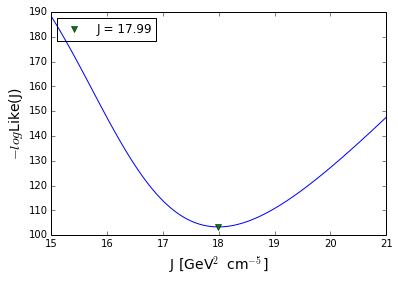

In [237]:
plt.plot(J_array,LikeJi)
plt.plot(min_LikeJ.x,spline_LikeJi(min_LikeJ.x),'v',label=r'J = %.2f'%min_LikeJ.x)
plt.legend(numpoints=1,loc='upper left',fontsize=12)
plt.xlabel('J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylabel(r'$-log$Like(J)',fontsize=14)
plt.savefig('output/%s/LikeJ_1pkc_%s.png'%(dwarf,dwarf),dpi=300,format='png')

This gives a reasonable result, although the minimum J is biased by the choice $r_0$ = 1 kpc. The existence of a minimum for the likelihood function along a J isocurve, indicates that the fitting scheme can be savely employed, with some expedient. This is done in the following

In [238]:
J_array = np.linspace(Jint,Jend,100)
min_LikeJ = np.zeros_like(J_array)
LikeJ_values = np.zeros_like(r0_array)
for i,J in enumerate(J_array):
    for j,r0 in enumerate(r0_array):
        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j),tol=1.e-10)
        LikeJ_values[j] = logLike(10.**log10rho0.x*r0**3.,j)
    spline_LikeJ = spline(r0_array,LikeJ_values,s=0)
    min_r0 = sciopt.minimize_scalar(spline_LikeJ,bracket=(0.1,2),tol=1.e-10)
    neg_spline = lambda J : -spline_LikeJ(J)
    if min_r0.x < 0:
        min_LikeJ[i] = spline_LikeJ(sciopt.minimize_scalar(neg_spline,bracket=(0.1,2),
                                                           tol=1.e-10).x)
    else:
        min_LikeJ[i] = spline_LikeJ(min_r0.x)

In [239]:
spline_Like = spline(np.delete(J_array,np.where(np.isnan(min_LikeJ))[0]),
                     np.delete(min_LikeJ,np.where(np.isnan(min_LikeJ))[0]))
min_J = sciopt.minimize_scalar(spline_Like,method='Bounded',
                               bounds=(J_array[0]+1.,J_array[-1]-1.),tol=1e-10)

def one_sigmaJ(J):
    return abs(spline_Like(J)-spline_Like(min_J.x)-0.5)

err_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',
                               bounds=(J_array[0]+1.,min_J.x),tol=1.e-10).x-min_J.x
err_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',
                               bounds=(min_J.x,J_array[-1]-1.),tol=1.e-10).x-min_J.x
print err_l,err_r
print "The Maximum Likelihood J for %s is %.2f +%.3f %.3f"%(dwarf,min_J.x,err_r,err_l)

-0.210018852265 0.218092865255
The Maximum Likelihood J for umaI is 18.08 +0.218 -0.210


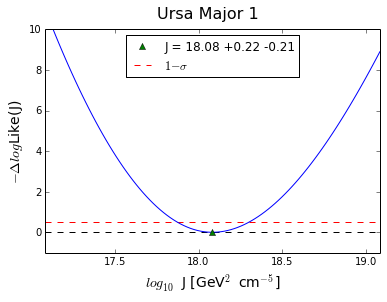

In [240]:
J_new = np.linspace(min_J.x-1,min_J.x+1,100)
plt.plot(J_new,spline_Like(J_new)-spline_Like(min_J.x))
plt.plot(min_J.x,0.,'^',label='J = %.2f +%.2f %.2f'%(min_J.x,err_r,err_l))
plt.hlines(0.,min(J_new),max(J_new),linestyles='dashed')
plt.hlines(.5,min(J_new),max(J_new),colors=('r'),linestyles='dashed',label=r'$1-\sigma$')
plt.legend(numpoints=1,loc='upper center',fontsize=12)
plt.ylabel(r'$-\Delta$$log$Like(J)',fontsize=14)
plt.xlabel(r'$log_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-1,10)
plt.xlim(min_J.x-1,min_J.x+1)
plt.suptitle('%s'%names[dwarf],fontsize=16)
plt.savefig('output/%s/LikeJ_%s.png'%(dwarf,dwarf),dpi=300,format='png')

In [241]:
import yaml
results = {'dwarf':dwarf,'Jmin':float(min_J.x),'Jplus':float(err_r),
           'Jminus':float(err_l),'Nstars':Nstars}
yaml.dump(results,open('output/%s/results_%s.yaml'%(dwarf,dwarf),'w'),
          default_flow_style=False)

# Fitting $\beta$

We can now let $\beta$ vary and fit it within the previous scheme with a slight modification: In step 4, we can fit the Likelihood for $\beta$ rather than simply evaluating it at $\rho_0,r_0$. First an analysis of the various parts of $\sigma_{l.o.s.}$ for different $\beta$

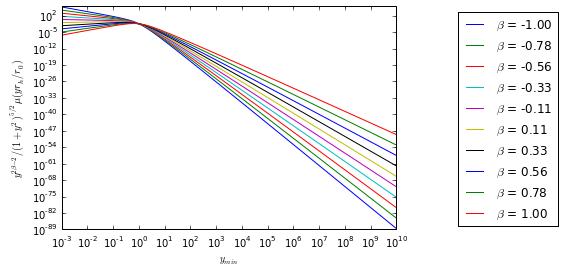

In [262]:
for beta in np.linspace(-1,1,10):
    int1_y=np.logspace(-3, 10, 100)
    plt.loglog(int1_y,integrand1(int1_y,alpha_array[14],beta), #alpha_array[14]~1kpc
               '-',label=r'$\beta$ = %.2f'%beta)
plt.legend(bbox_to_anchor=(1.5, 1.))
plt.xlabel(r'$y_{min}$')
plt.ylabel(r'$y^{2\beta-2}/(1+y^2)^{5/2}\mu(yr_h/r_0)$')

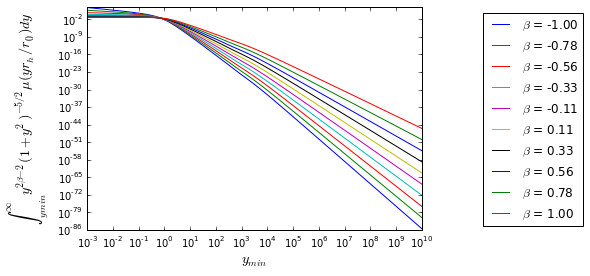

In [265]:
for beta in np.linspace(-1,1,10):
    ymin=np.logspace(-3, 10, 100)
    plt.loglog(ymin,[integral1(y,alpha_array[14],beta)[0] for y in ymin],
               '-',label=r'$\beta$ = %.2f'%beta)
plt.legend(bbox_to_anchor=(1.5, 1.))
plt.xlabel(r'$y_{min}$',fontsize=14)
plt.ylabel(r'$\int^\infty_{ymin}y^{2\beta-2}(1+y^2)^{-5/2}\mu(yr_h/r_0)dy$',fontsize=14)

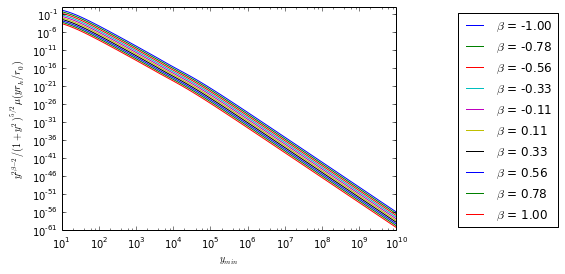

In [263]:
for beta in np.linspace(-1,1,10):
    z=np.logspace(1,10,100)
    plt.loglog(z,[integrand2(zi,alpha_array[14],beta,gamma_array[0]) for zi in z],
               '-',label=r'$\beta$ = %.2f'%beta)
plt.legend(bbox_to_anchor=(1.5, 1.))
plt.xlabel(r'$y_{min}$')
plt.ylabel(r'$y^{2\beta-2}/(1+y^2)^{5/2}\mu(yr_h/r_0)$')

In [266]:
beta_array = np.linspace(-1,1,50)
# this will take approx. 5 hours but allows to vectorize the profiling over Beta
sigma_beta_array = np.array([[[integral2(alpha,beta,gamma)*gamma**(1.-2.*beta)/
                               I(gamma*rh,rh,1.) for alpha in alpha_array] 
                              for gamma in gamma_array] for beta in beta_array],dtype=float)

np.save('output/%s/sigma_beta1_%s'%(dwarf,dwarf),sigma_beta_array)

In [267]:
#sigma_beta_array = np.load('output/%s/sigma_beta_%s.npy'%(dwarf,dwarf))
def LikeBeta(log10rho0,r0,beta):
    M0 = 10.**log10rho0*r0_array[r0]**3
    I = cst*M0*sigma_beta_array[beta,:,r0]
    S = dv**2+I
    res = (np.log(S) + (v-u)**2/S).sum()
    return res/2.

In [268]:
print sigma_beta_array.shape

(50, 39, 50)


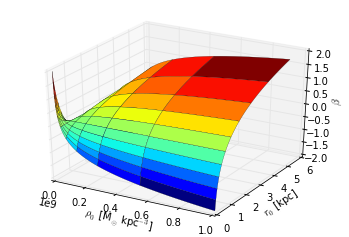

In [190]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
x = rho0_array
y = r0_array
z = beta_array
X, Y = np.meshgrid(x, y)
Z = np.outer(z.T, z)
#colors = np.array([[[LikeBeta(yi,j,k) for yi in y] for j in range(100)] for k in range(100)])
#color_dimension = colors
#minn, maxx = color_dimension.min(), color_dimension.max()
#norm = matplotlib.colors.Normalize(minn, maxx)
#m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
#m.set_array([])
#fcolors = m.to_rgba(color_dimension)
ax.plot_surface(X,Y,Z/2.,cmap=cm.jet, linewidth=0.2)
ax.set_xlabel(r'$\rho_0$ [M$_\odot$ kpc$^{-3}$]')
ax.set_ylabel(r'$r_0$ [kpc]')
ax.set_zlabel(r'$\beta$')

As previously, examine first the behaviour along a test J isocurve to verify that profiling over beta does lead to a minimum of -log$Like(\rho_0,r_0,\beta)$

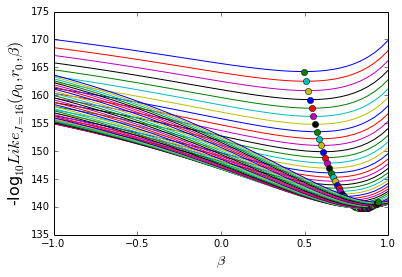

In [282]:
LikeBetak = np.zeros_like(beta_array)
Jtest = 16
LikeJk = np.zeros_like(beta_array)
for k,r0 in enumerate(r0_array):
    log10rho0k = sciopt.minimize_scalar(deltaJ,args=(Jtest,k),tol=1.e-10).x
    for b,beta in enumerate(beta_array):
        LikeBetak[b] = LikeBeta(log10rho0k,k,b)
    spline_LikeBeta = spline(beta_array,LikeBetak,s=0)
    min_betak = sciopt.minimize_scalar(spline_LikeBeta,tol=1.e-10)
    LikeJk[k] = min_betak.fun
    plt.plot(beta_array,spline_LikeBeta(beta_array))
    plt.plot(min_betak.x,min_betak.fun,'o')
plt.xlabel(r'$\beta$',fontsize=14)
plt.ylabel(r'-log$_{10} Like_{J=%i}(\rho_0,r_0,\beta)$'%Jtest,fontsize=16)

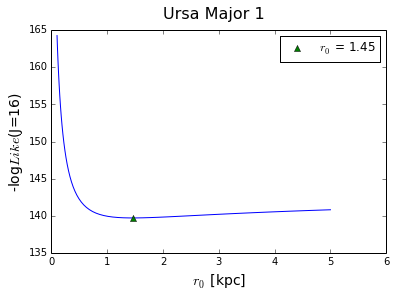

In [284]:
spline_Like = spline(r0_array,LikeJk,s=0)
min_LikeBeta = sciopt.minimize_scalar(spline_Like,method='Bounded',bounds=(0.1,2),tol=1.e-10)
plt.plot(r0_array,LikeJk,'-')
plt.plot(min_LikeBeta.x,spline_Like(min_LikeBeta.x),'^',label=r'$r_0$ = %.2f'%min_LikeBeta.x)
#plt.xlim(0,5)
plt.ylabel(r'-log$Like$(J=%i)'%Jtest,fontsize=14)
plt.xlabel(r'$r_0$ [kpc]',fontsize=14)
plt.legend(numpoints=1,loc='upper right',fontsize=12)
plt.suptitle('%s'%names[dwarf],fontsize=16)
plt.savefig('output/%s/LikeJ%i_beta_%s.png'%(dwarf,Jtest,dwarf),dpi=300,format='png')

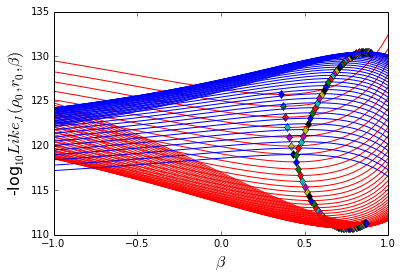

In [379]:
color =['r','b']
for c,J in enumerate((17.,20.)):
    for j,r0 in enumerate(r0_array):
        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j),tol=1.e-10).x
        for b,beta in enumerate(beta_array):
            LikeBetak[b] = LikeBeta(log10rho0,j,b)
        spline_LikeBeta = spline(beta_array,LikeBetak,s=0)
        min_beta = sciopt.minimize_scalar(spline_LikeBeta,method='Bounded',
                                           bounds=(-.99,.99),tol=1.e-10)
        neg_spline_beta = lambda J : -spline_LikeBeta(J)
        if beta_array[0]+0.1<min_beta.x<beta_array[-1]-0.1:
            minib = min_beta.x
            LikeJj = spline_LikeBeta(min_beta.x)
            plt.plot(beta_array,spline_LikeBeta(beta_array),'%s-'%color[c])
            plt.plot(minib,LikeJj,'d')
        else:
            maxb = sciopt.minimize_scalar(neg_spline_beta,method='Bounded',
                                           bounds=(-.99,.99),tol=1.e-10).x
            if beta_array[0]+0.1<maxb<beta_array[-1]-0.1:
                LikeJj = spline_LikeBeta(maxb)
                plt.plot(beta_array,spline_LikeBeta(beta_array),'%s-'%color[c])
                plt.plot(maxb,LikeJj,'d')
plt.ylabel(r'-log$_{10} Like_J(\rho_0,r_0,\beta)$',fontsize=16)
plt.xlabel(r'$\beta$',fontsize=16)

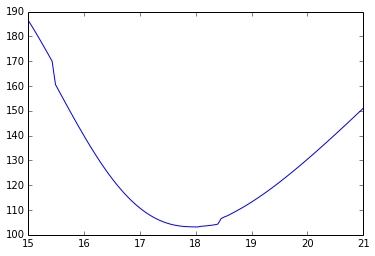

In [429]:
LikeJ = np.empty([0])
J_new = np.empty([0])
for c,J in enumerate(J_array):
    LikeJbeta = np.empty([0])
    r0_new = np.empty([0])
    for j,r0 in enumerate(r0_array):
        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j),tol=1e-8).x
        for b,beta in enumerate(beta_array):
            LikeBetak[b] = LikeBeta(log10rho0,j,b)
        spline_LikeBeta = spline(beta_array,LikeBetak,s=0)
        min_beta = sciopt.minimize_scalar(spline_LikeBeta,method='Bounded',
                                           bounds=(-.99,.99),tol=1.e-10)
        neg_spline_beta = lambda J : -spline_LikeBeta(J)
        if beta_array[0]+0.1<min_beta.x<beta_array[-1]-0.1:
            minib = min_beta.x
            r0_new = np.append(r0_new,r0)
            LikeJbeta = np.append(LikeJbeta,spline_LikeBeta(minib))
        else:
            maxb = sciopt.minimize_scalar(neg_spline_beta,method='Bounded',
                                           bounds=(-.99,.99),tol=1.e-10).x
            if beta_array[0]+0.1<maxb<beta_array[-1]-0.1:
                r0_new = np.append(r0_new,r0)
                LikeJbeta = np.append(LikeJbeta,spline_LikeBeta(maxb))
    
    spline_Like_r0 = spline(r0_new,LikeJbeta,s=0)
    min_LikeJ_r0 = sciopt.minimize_scalar(spline_Like_r0,method='Bounded',
                                    bounds=(r0_new[0],r0_new[-1]-0.1),tol=1.e-10).x
    neg_spline_r0 = lambda J : -spline_Like_r0(J)
    if r0_new[0]+0.2<min_LikeJ_r0<r0_new[-1]-0.2:
        J_new = np.append(J_new,J)
        #print '%10.4f %10.4f %10.4f %10.4f %10.4f'%\
        #(J,r0_new[0],min_LikeJ_r0,r0_new[-1],spline_Like_r0(min_LikeJ_r0))
        LikeJ = np.append(LikeJ,spline_Like_r0(min_LikeJ_r0))
    else:
        min_LikeJ_neg = sciopt.minimize_scalar(neg_spline_r0,method='Bounded',
                                        bounds=(r0_new[0]+0.2,r0_new[-1]-0.2),tol=1.e-10).x
        if r0_new[0]+0.2<min_LikeJ_neg<r0_new[-1]-0.2:
            J_new = np.append(J_new,J)
            #print '%10.4f %10.4f %10.4f %10.4f %10.4f'%\
            #(J,r0_new[0],min_LikeJ_neg,r0_new[-1],spline_Like_r0(min_LikeJ_neg))
            LikeJ = np.append(LikeJ,spline_Like_r0(min_LikeJ_neg))

plt.plot(J_new,LikeJ,'-')

In [436]:
spline_Like = spline(J_new,LikeJ)
min_J = sciopt.minimize_scalar(spline_Like,method='Bounded',
                               bounds=(J_new[0]+1.,J_new[-1]-1.),tol=1.e-10).x

def one_sigmaJ(J):
    return abs(spline_Like(J)-spline_Like(min_J)-0.5)
err_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',
                               bounds=(J_new[0]+1.,min_J),tol=1.e-10).x-min_J
err_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',
                               bounds=(min_J,J_new[-1]-1.),tol=1.e-10).x-min_J
print err_l,err_r
print "The Maximum Likelihood J for %s is %.2f +%.3f %.3f"%(dwarf,min_J,err_r,err_l)

-0.24038860974 0.244956447525
The Maximum Likelihood J for umaI is 17.91 +0.245 -0.240


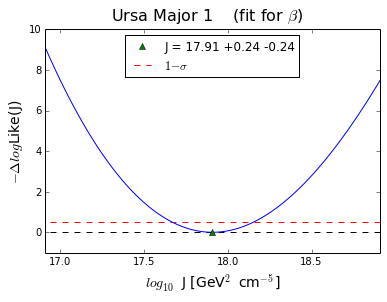

In [437]:
J_new = np.linspace(min_J-1,min_J+1,100)
plt.plot(J_new,spline_Like(J_new)-spline_Like(min_J))
plt.plot(min_J,0.,'^',label='J = %.2f +%.2f %.2f'%(min_J,err_r,err_l))
plt.hlines(0.,min(J_array),max(J_array),linestyles='dashed')
plt.hlines(.5,min(J_array),max(J_array),colors=('r'),linestyles='dashed',label=r'$1-\sigma$')
plt.legend(numpoints=1,loc='upper center',fontsize=12)
plt.ylabel(r'$-\Delta$$log$Like(J)',fontsize=14)
plt.xlabel(r'$log_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-1,10)
plt.xlim(min_J-1,min_J+1)
plt.suptitle('%s'%names[dwarf]+'\t'+r'(fit for $\beta$)',fontsize=16)
plt.savefig('output/%s/LikeJbeta_%s.png'%(dwarf,dwarf),dpi=300,format='png')